In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '../data/datafix.csv'

concat_select = pd.read_csv(datafix)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [3]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029552, 48) (9272, 48)


In [4]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
1029552,개포6차우성,79.97,26,5,1987,언주로 3,아파트,분양,자치관리,계단식,...,1,중형,-0.806003,1,2,2,8학군,0.80757,3.5,0


In [5]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

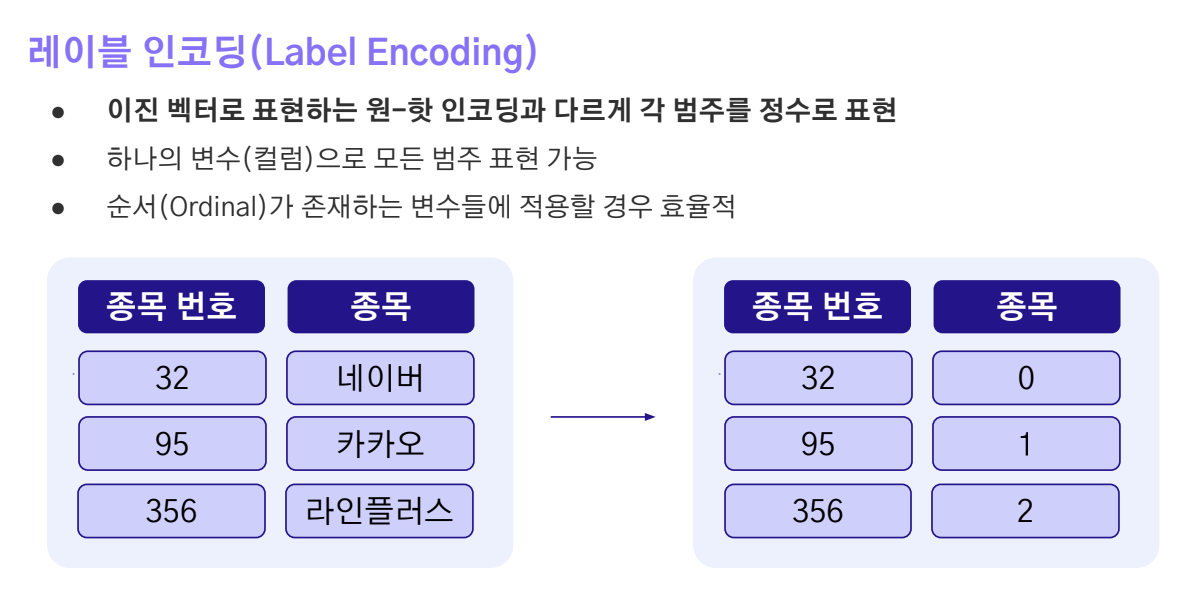

In [6]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '계약년', '계약월', '강남여부', '가격상승률', '동등급', '브랜드등급', '한강근접여부', '지하철거리', '기준금리', '신축여부']
범주형 변수: ['아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '단지신청일', '구', '동', '평형대', '학군']


In [7]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                    0
is_test                   0
구                   

In [9]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 21/21 [00:06<00:00,  3.28it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [10]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [11]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [19]:
# !pip install pytorch_tabnet

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

model = TabNetRegressor(verbose=2,
                        seed=42,
                        optimizer_fn=torch.optim.AdamW,
                        device_name='cuda')

model.fit(X_train=X_train.to_numpy(),y_train=y_train.to_numpy().reshape(-1,1),
          eval_set=[(X_val.to_numpy(),y_val.to_numpy().reshape(-1,1))],
          patience=50,
          max_epochs=100000,
          eval_metric=['rmse'])


epoch 0  | loss: 3589286374.20896| val_0_rmse: 51563.34423|  0:00:31s
epoch 2  | loss: 929425597.69154| val_0_rmse: 21132.57998|  0:01:34s
epoch 4  | loss: 218652747.83085| val_0_rmse: 15821.34307|  0:02:37s
epoch 6  | loss: 65996226.75249| val_0_rmse: 9631.07268|  0:03:40s
epoch 8  | loss: 35866499.7699| val_0_rmse: 6129.30449|  0:04:43s
epoch 10 | loss: 27530286.30348| val_0_rmse: 6436.1315|  0:05:46s
epoch 12 | loss: 25033950.71082| val_0_rmse: 11440.40755|  0:06:49s
epoch 14 | loss: 24735765.4944| val_0_rmse: 3066.8989|  0:07:53s
epoch 16 | loss: 22655069.62313| val_0_rmse: 11906.4196|  0:08:56s
epoch 18 | loss: 21301110.23134| val_0_rmse: 9908.70728|  0:09:59s
epoch 20 | loss: 22531180.47264| val_0_rmse: 12275.54646|  0:11:02s
epoch 22 | loss: 21593053.22077| val_0_rmse: 6442.2522|  0:12:06s
epoch 24 | loss: 21698385.24813| val_0_rmse: 8300.18629|  0:13:09s
epoch 26 | loss: 19879777.10697| val_0_rmse: 3054.38558|  0:14:12s
epoch 28 | loss: 21228602.82338| val_0_rmse: 12039.25132| 

이미 val pred RMSE가 위에 나와 있지만 그래도 보기 편하라고 한번 더 보여드림.

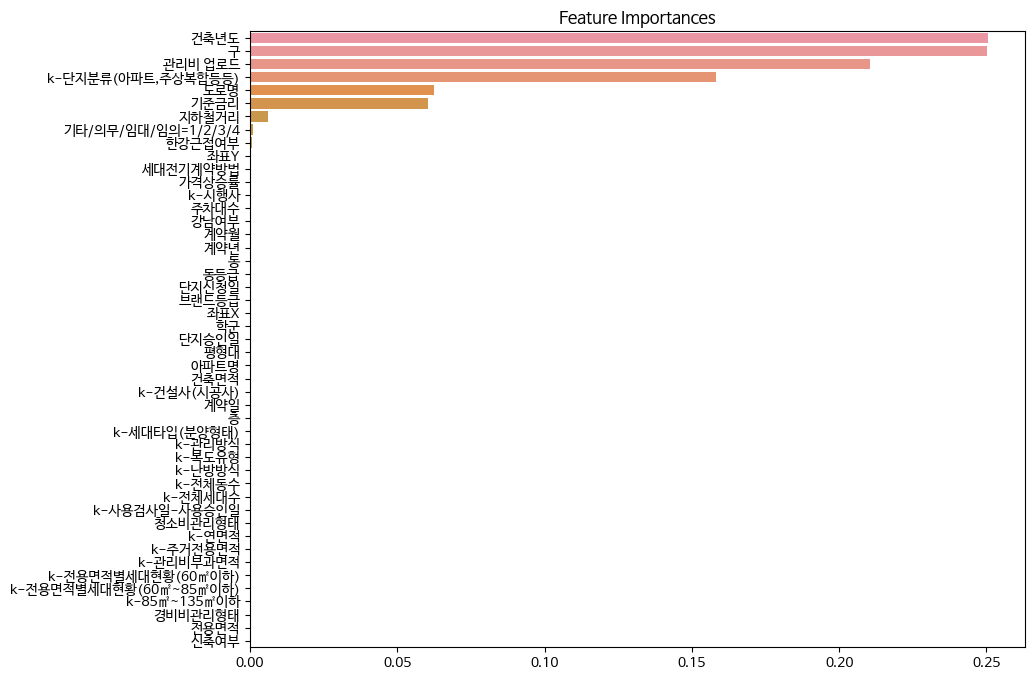

In [20]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [21]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [22]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=len(X_val.columns))    # valid data에 대해 적합시킵니다.

KeyError: 0

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [17]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [18]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [19]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [20]:
X_val_sort.head()

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
197282,575,117.11,17,3,1984,3934,0,0,0,0,...,1,2,1,9,0.554552,3.5,0,243000.0,341415.628813,9.685636e+09
194790,3572,112.96,29,7,2016,5028,3,1,1,5,...,1,2,1,9,0.598305,3.5,0,470000.0,393583.298696,5.839512e+09
197723,2773,108.93,17,27,2018,609,3,1,1,5,...,1,1,2,0,0.588393,3.5,1,239000.0,305528.107293,4.425989e+09
185574,1518,94.49,16,15,2015,3990,0,0,0,0,...,1,1,2,9,0.714526,3.0,0,348000.0,407962.953378,3.595556e+09
197285,1557,84.95,1,26,2023,0,0,0,0,0,...,1,1,1,9,0.556594,3.5,1,360000.0,302888.310491,3.261745e+09


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [21]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [22]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [23]:
display(error_top100.head(5))
display(best_top100.head(1))

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
197282,궁전,117.11,17,3,1984,사평대로 142,nan,nan,nan,nan,...,1,2,1,8학군,0.554552,3.5,0,243000.0,341415.628813,9.685636e+09
194790,아크로리버파크,112.96,29,7,2016,신반포로15길 19,아파트,기타,위탁관리,혼합식,...,1,2,1,8학군,0.598305,3.5,0,470000.0,393583.298696,5.839512e+09
197723,서울숲리버뷰자이,108.93,17,27,2018,고산자로2길 65,아파트,기타,위탁관리,혼합식,...,1,1,2,10학군,0.588393,3.5,1,239000.0,305528.107293,4.425989e+09
185574,래미안대치팰리스,94.49,16,15,2015,삼성로51길 37,nan,nan,nan,nan,...,1,1,2,8학군,0.714526,3.0,0,348000.0,407962.953378,3.595556e+09
197285,래미안원베일리,84.95,1,26,2023,,nan,nan,nan,nan,...,1,1,1,8학군,0.556594,3.5,1,360000.0,302888.310491,3.261745e+09


,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
64844,가락쌍용,59.92,27,12,1997,동남로 193,nan,nan,nan,nan,...,1,2,2,6학군,0.91717,1.5,0,72000.0,71999.906286,0.008782


- 이제 분포를 비교해보도록 하겠습니다.

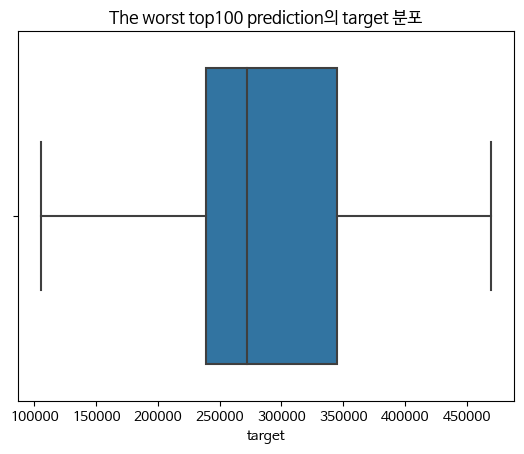

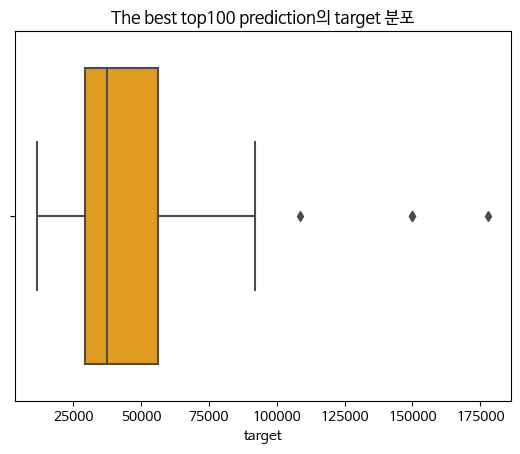

In [24]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

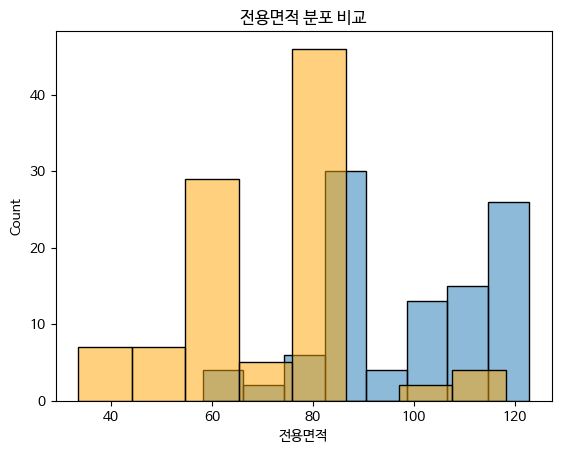

In [25]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [26]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
1029552,293,79.9700,26,5,1987,5520,3,2,2,1,...,1,2,-0.806003,1,2,2,9,0.807570,3.5,0
1029553,294,108.2017,15,10,2021,431,3,2,1,1,...,1,0,-0.806003,1,1,2,9,0.787231,3.5,1


In [27]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [28]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 81.6 ms, sys: 0 ns, total: 81.6 ms
Wall time: 13.9 ms


In [29]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([16954.52897134, 17596.15394061, 18064.26974278, ...,
       16841.64518765, 17571.66958339, 17601.05483659])

## 7. Output File Save

In [30]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)